# Influence functions for Large Language Models

This notebooks showcases the use of influence functions for large language models. In particular, it focuses on sentiment analysis using the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) and a fine-tuned [BERT](https://arxiv.org/abs/1810.04805) model.

Not all the methods for influence function calculation can scale to large models and datasets. In this notebook we will use the [Kronecker-Factored Approximate Curvature](https://arxiv.org/abs/1503.05671) method, which is the only one that can scale to current state-of-the-art language models.

The notebook is structured as follows:

- [Setup](#Setup) imports the required libraries and downloads the dataset and the model.
- [Sentiment analysis](#Sentiment-analysis) loads the model and the dataset and goes through a few examples of sentiment analysis.
- [Model and data preparation](#Model-and-data-preparation) prepares the model and the dataset for influence function calculation. In particular, it assigns all the linear layers to require gradients and wraps the model so that only logits are returned (and not the loss or attention masks).
- [Influence function computation](#Influence-function-computation): shows how to calculate the influence function for a few test and train examples.
- [Analysis of influence values](#Analysis-of-influence-values): analyses the influence values, trying to extract general information about the model and how it is affected by corruption in the training data.
- [Influence functions by layer](#Influence-functions-by-layer): since ekfac is based on a block diagonal approximation of the Fisher information matrix, we can compute the influence function separately for each layer of the neural network. This section shows how to do that and how to analyse the results.

Finally, the [Appendix](#Appendix) shows how to select the Hessian regularization parameter to obtain the best influence function approximation.

<div class="alert alert-info">

If you are reading this in the documentation, some boilerplate has been omitted for convenience.

</div>

## Setup

In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's start by importing the required libraries. If not already installed, you can install them with `pip install -r requirements-notebooks.txt`.

In [7]:
from copy import deepcopy
from typing import Sequence

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from datasets import load_dataset
from IPython.display import HTML, display
from sklearn.metrics import f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from pydvl.influence.torch import EkfacInfluence
from support.torch import ImdbDataset, ModelLogitsWrapper

In [8]:
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Sentiment Analysis

Sentiment analysis is the task of classifying a sentence as having a positive or negative sentiment. For example, the sentence "I love this movie" has a positive sentiment, while "I hate this movie" has a negative sentiment. In this notebook we will use the IMDB dataset, which contains 50,000 movie reviews with corresponding labels. The dataset is split into 25,000 reviews for training and 25,000 reviews for testing. The dataset is balanced, meaning that there are the same number of positive and negative reviews in the training and test set.

In [10]:
imdb = load_dataset("imdb")

Let's print an example of review and its label

In [11]:
sample_review = imdb["train"].select([24])

print(f"Here is a sample review with label {sample_review['label'][0]}: \n")

display(HTML(sample_review["text"][0].split("<br />")[0]))
display(HTML(sample_review["text"][0].split("<br />")[-1]))

Here is a sample review with label 0: 



The review is negative, and so label 0 is associated to negative sentiment.

The model is a BERT model fine-tuned on the IMDB dataset. BERT is a large language model that has been pre-trained on a large corpus of text. The model was fine-tuned on the IMDB dataset by AssemblyAI and is available on the HuggingFace model hub. We also load its tokenizer, which is used to convert sentences into numeric tokens.

In [12]:
tokenizer = AutoTokenizer.from_pretrained("assemblyai/distilbert-base-uncased-sst2")
model = AutoModelForSequenceClassification.from_pretrained(
    "assemblyai/distilbert-base-uncased-sst2"
)

Even if the model is trained on movie reviews, it can be used to classify any sentence as positive or negative. Let's try it on a simple sentence created by us.

In [13]:
example_phrase = (
    "Pydvl is the best data valuation library, and it is fully open-source!"
)

tokenized_example = tokenizer(
    [example_phrase],
    return_tensors="pt",
    truncation=True,
)

model_output = model(
    input_ids=tokenized_example.input_ids,
)

The model output is a `SequenceClassificationOutput` object, which contains the logits and other information.

In [14]:
print("Model Output:\n", model_output)

Model Output:
 SequenceClassifierOutput(loss=None, logits=tensor([[-2.6237,  2.8350]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


For calculating probabilities and for the influence functions we only need the logits. Then the softmax function converts the logits into probabilities.

In [15]:
model_predictions = F.softmax(model_output.logits, dim=1)

The model is quite confident that the sentence has a positive sentiment, which is correct.

In [16]:
print(
    "Positive probability: " + str(round(model_predictions[0][1].item(), 3) * 100) + "%"
)
print(
    "Negative probability: " + str(round(model_predictions[0][0].item(), 3) * 100) + "%"
)

Positive probability: 99.6%
Negative probability: 0.4%


Let's examine the model's f1 score on a small subset of the test set.

In [17]:
sample_test_set = imdb["test"].shuffle(seed=seed).select(range(50))
sample_test_set = sample_test_set.map(
    lambda example: tokenizer(example["text"], truncation=True, padding="max_length"),
    batched=True,
)
sample_test_set.set_format("torch", columns=["input_ids", "attention_mask", "label"])
model.eval()
with torch.no_grad():
    logits = model(
        input_ids=sample_test_set["input_ids"],
        attention_mask=sample_test_set["attention_mask"],
    ).logits
    predictions = torch.argmax(logits, dim=1)

In [18]:
f1_score_value = f1_score(sample_test_set["label"], predictions)
print(f"F1 Score: {round(f1_score_value, 3)}")

F1 Score: 0.955


## Model and Data Preparation

In this section we will define two helper function and classes that will be used in the rest of the notebook. 

In [19]:
def print_sentiment_preds(
    model: ModelLogitsWrapper, model_input: torch.Tensor, true_label: int
):
    """
    Prints the sentiment predictions in a human-readable format given a model and an
    input. It also prints the true label.
    """
    model_predictions = F.softmax(model(model_input.unsqueeze(0)), dim=1)
    print(
        "Positive probability: "
        + str(round(model_predictions[0][1].item(), 3) * 100)
        + "%"
    )
    print(
        "Negative probability: "
        + str(round(model_predictions[0][0].item(), 3) * 100)
        + "%"
    )

    true_label = "Positive" if true_label == 1 else "Negative"
    print(f"True label: {true_label} \n")


def strip_layer_names(param_names: Sequence[str]):
    """
    Helper function that strips the parameter names of the model and the transformer,
    so that they can be printed and compared more easily.
    """
    stripped_param_names = []
    for name in param_names:
        name = name.replace("model.", "")
        if name.startswith("distilbert.transformer."):
            name = name.replace("distilbert.transformer.", "")
        stripped_param_names.append(name)
    return stripped_param_names

Importantly, we will need to assign all the linear layers to require gradients, so that we can compute the influence function with respect to them. Keep in mind that the current implementation of Ekfac only supports linear layers, so if any other type of layer in the model requires gradients the initialisation of the influence function class will fail.

In [20]:
for param in model.named_parameters():
    param[1].requires_grad = False

for m_name, module in model.named_modules():
    if len(list(module.children())) == 0 and len(list(module.parameters())) > 0:
        if isinstance(module, torch.nn.Linear):
            for p_name, param in module.named_parameters():
                if "pre_classifier" in m_name or "classifier" in m_name:
                    param.requires_grad = True

Albeit restrictive, linear layers constitute a large fraction of the parameters of most large language models, and so our analysis still holds a lot of information about the full neural network.

In [21]:
total_params = sum(p.numel() for p in model.parameters()) / 1e6
params_requiring_grad = (
    sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
)

print("Total parameters: {:.2f} millions".format(total_params))
print("Parameters requiring gradients: {:.2f} millions".format(params_requiring_grad))
print(
    "Ratio of Linear over other layer types: {:.2f}%".format(
        (params_requiring_grad / total_params) * 100
    )
)

Total parameters: 66.96 millions
Parameters requiring gradients: 0.59 millions
Ratio of Linear over other layer types: 0.88%


## Influence function computation

We are now ready to compute the influence function for a few testing and training examples. Let's start by selecting a subset of the full training and testing dataset and wrapping them in a `DataLoader` object, so that we can easily do batching.

In [22]:
NUM_TRAIN_EXAMPLES = 100
NUM_TEST_EXAMPLES = 100

small_train_dataset = (
    imdb["train"]
    .shuffle(seed=seed)
    .select([i for i in list(range(NUM_TRAIN_EXAMPLES))])
)
small_test_dataset = (
    imdb["test"].shuffle(seed=seed).select([i for i in list(range(NUM_TEST_EXAMPLES))])
)

train_dataset = ImdbDataset(small_train_dataset, tokenizer=tokenizer)
test_dataset = ImdbDataset(small_test_dataset, tokenizer=tokenizer)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=7, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

For influence computation we need to take the model in evaluation mode, so that no dropout or batch normalization is applied. Then, we can fit the Ekfac representation.

In [23]:
wrapped_model = ModelLogitsWrapper(model)
wrapped_model.eval()

ekfac_influence_model = EkfacInfluence(
    wrapped_model,
    progress=True,
)
ekfac_influence_model = ekfac_influence_model.fit(train_dataloader)

K-FAC blocks - batch progress:   0%|          | 0/15 [00:00<?, ?it/s]

And the approximate Hessian is thus obtained. Considering that the model has almost 30 million parameters requiring gradients, this was very fast! Of course, this Hessian is computed using only a very small fraction (~0.4%) of the training data, and for a better approximation we should use a larger subset.

Before continuing, we need to set the Hessian regularization parameter to an appropriate value. A way to decide which is better can be found in the [Appendix](#Appendix). Here, we will just set it to 1e-5.

In [24]:
ekfac_influence_model.hessian_regularization = 1e-5

We calculate the influence of the first batch of training data over the first batch of test data. This is because influence functions are very expensive to compute, and so to keep the runtime of this notebook within a few minutes we need to restrict ourselves to a small number of examples.

In [25]:
test_input, test_labels, test_text = next(iter(test_dataloader))
train_input, train_labels, train_text = next(iter(train_dataloader))

And let's finally compute the influence function values

In [26]:
ekfac_train_influences = ekfac_influence_model.influences(
    test_input,
    test_labels,
    train_input,
    train_labels,
)

/Users/jakobkruse/Documents/Projects/pyDVL/venv/lib/python3.11/site-packages/transformers/models/distilbert/modeling_distilbert.py:245: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:85.)
  scores = scores.masked_fill(


## Analysis of influence values

Now that we have calculated the influences for a few examples, let's analyse some of the extreme values.

### Negative influence training examples

Let's plot the influence values as a heatmap for easily spotting patterns.

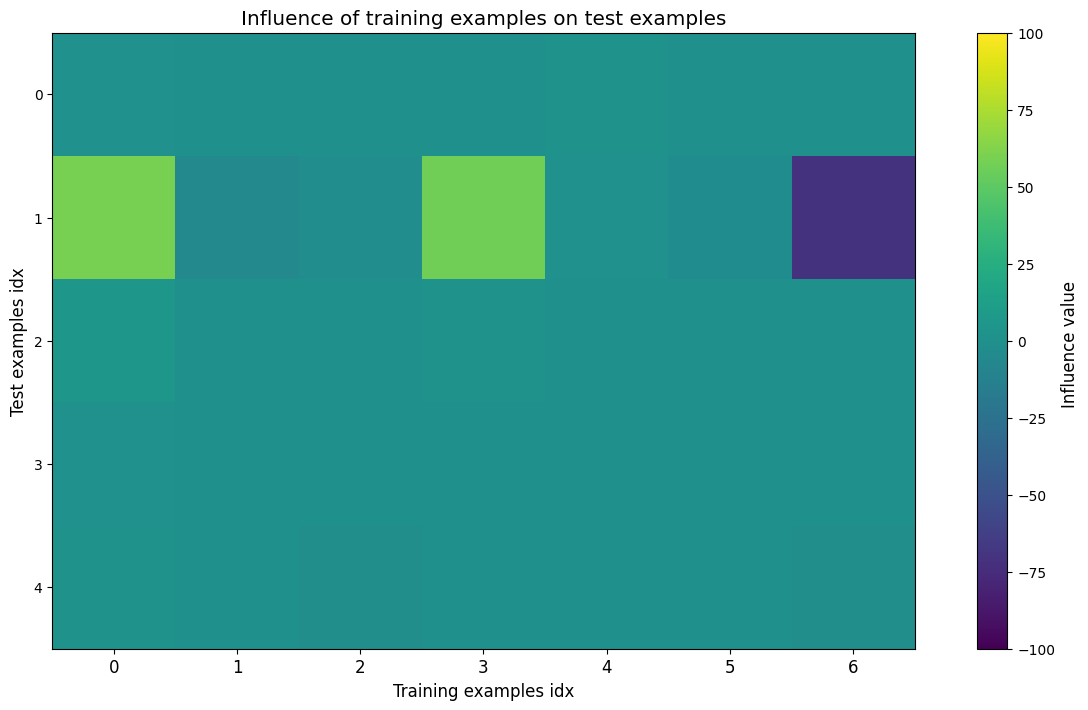

In [27]:
plt.imshow(ekfac_train_influences.numpy().astype(int), vmin=-100, vmax=100)
plt.colorbar(label="Influence value ")
plt.title("Influence of training examples on test examples")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Most of the test and training examples have similar influence, close to zero. However, there is one test and one training samples that stand out. In particular, their cross influence is very large and negative. Let's examine them more closely.

In [28]:
train_sentence_idx = 6

print(f"Training example with idx {train_sentence_idx}: \n")

print_sentiment_preds(
    wrapped_model,
    train_input[train_sentence_idx],
    train_labels[train_sentence_idx].item(),
)

print("Sentence:")
display(HTML(train_text[train_sentence_idx]))

Training example with idx 6: 

Positive probability: 92.80000000000001%
Negative probability: 7.199999999999999%
True label: Positive 

Sentence:


We can see that, despite being positive, this review is quite hard to classify because its language is rather neutral.

In [29]:
test_sentence_idx = 1

print(f"Test example with idx {test_sentence_idx}: \n")

print_sentiment_preds(
    wrapped_model, test_input[test_sentence_idx], test_labels[test_sentence_idx].item()
)

print("Sentence:")
display(HTML(test_text[test_sentence_idx]))

Test example with idx 1: 

Positive probability: 40.300000000000004%
Negative probability: 59.699999999999996%
True label: Negative 

Sentence:


This review is also quite hard to classify. This time it has a negative sentiment towards the movie, but it also contains several words with positive connotation.

As it is often the case when analysing influence functions, it is hard to understand why these examples have such a large influence. We have seen some interesting patterns, mostly related to similarities in the language and words used, but it is hard to say with certainty if these are the reasons for such a large influence.

A [recent paper](https://arxiv.org/abs/2308.03296) has explored this topic in high detail, even for much larger language models than BERT (up to ~50 billion parameters!). Among the most interesting findings is that smaller models tend to rely a lot on word-to-word correspondencies, while larger models are more capable of extracting higher level concepts, drawing connections between words across multiple phrases.

For more info, you can visit our [blog on influence functions for large language models](https://transferlab.ai/pills/2023/llm-influences-with-ekfac/)

### Influence of corrupted training examples

In this sections we want to get an idea of how influence functions change when training examples are corrupted. In the next cell we will flip the label of all the training examples and compute the influences on the same test batch as before.

In [30]:
modified_train_labels = deepcopy(train_labels)
modified_train_labels = 1 - train_labels

corrupted_ekfac_train_influences = ekfac_influence_model.influences(
    test_input,
    test_labels,
    train_input,
    modified_train_labels,
)

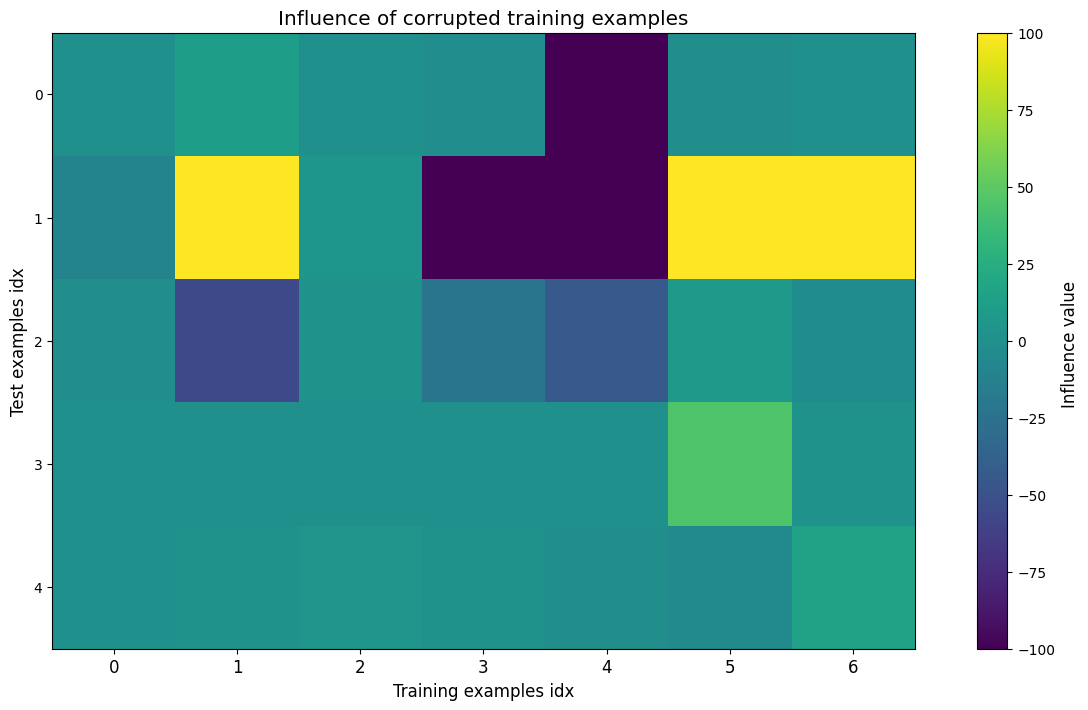

In [31]:
plt.imshow(corrupted_ekfac_train_influences.numpy().astype(int), vmin=-100, vmax=100)
plt.colorbar(label="Influence value ")
plt.title("Influence of corrupted training examples")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Overall, when corrupted the influences tend to become negative, as expected. Nevertheless, there are cases where values go from slightly negative to positive, mostly isolated to the second and last test samples. Single values can be quite noisy, so it is difficult to generalise this result, but it would be interesting to see how common these cases are in the full test dataset.

## Influence functions by layer

Since ekfac is based on a block diagonal approximation of the Fisher information matrix, we can compute the influence functions separately for each layer of the neural network. In this section we show how to do that and we briefly analyse the results.

In [32]:
influences_by_layer = ekfac_influence_model.influences_by_layer(
    test_input,
    test_labels,
    train_input,
    train_labels,
)

The method `influences_by_layer` returns a dictionary containing the influence function values for each layer of the neural network as a tensor. To recover the full influence values as returned by the `influences` (as done in the previous section), we need to sum each layer's values.

In [33]:
influences = torch.zeros_like(ekfac_train_influences)
for layer_id, value in influences_by_layer.items():
    influences += value.detach()

And if we plot the result as a heatmap we can see that the results are the same as in [Negative influence training examples](#Negative-influence-training-examples)

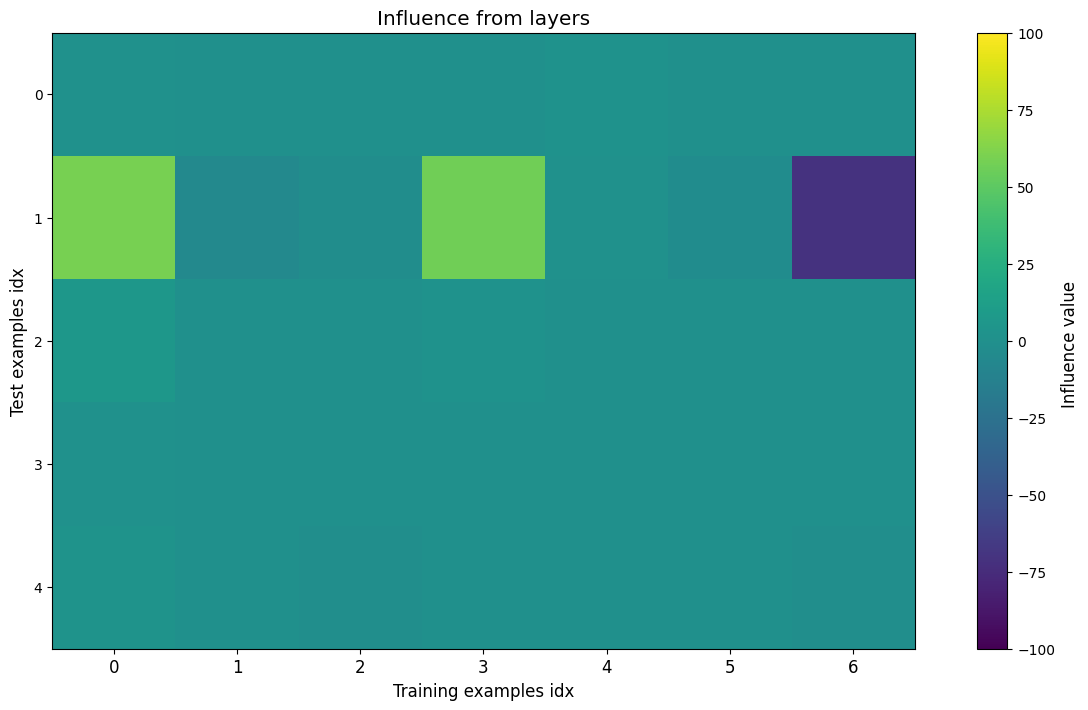

In [34]:
plt.imshow(influences.numpy().astype(int), vmin=-100, vmax=100)
plt.colorbar(label="Influence value ")
plt.title("Influence from layers")
plt.xlabel("Training examples idx")
plt.ylabel("Test examples idx")
plt.show()

Let's analyse how the influence values change across different layers for given test and train examples. 

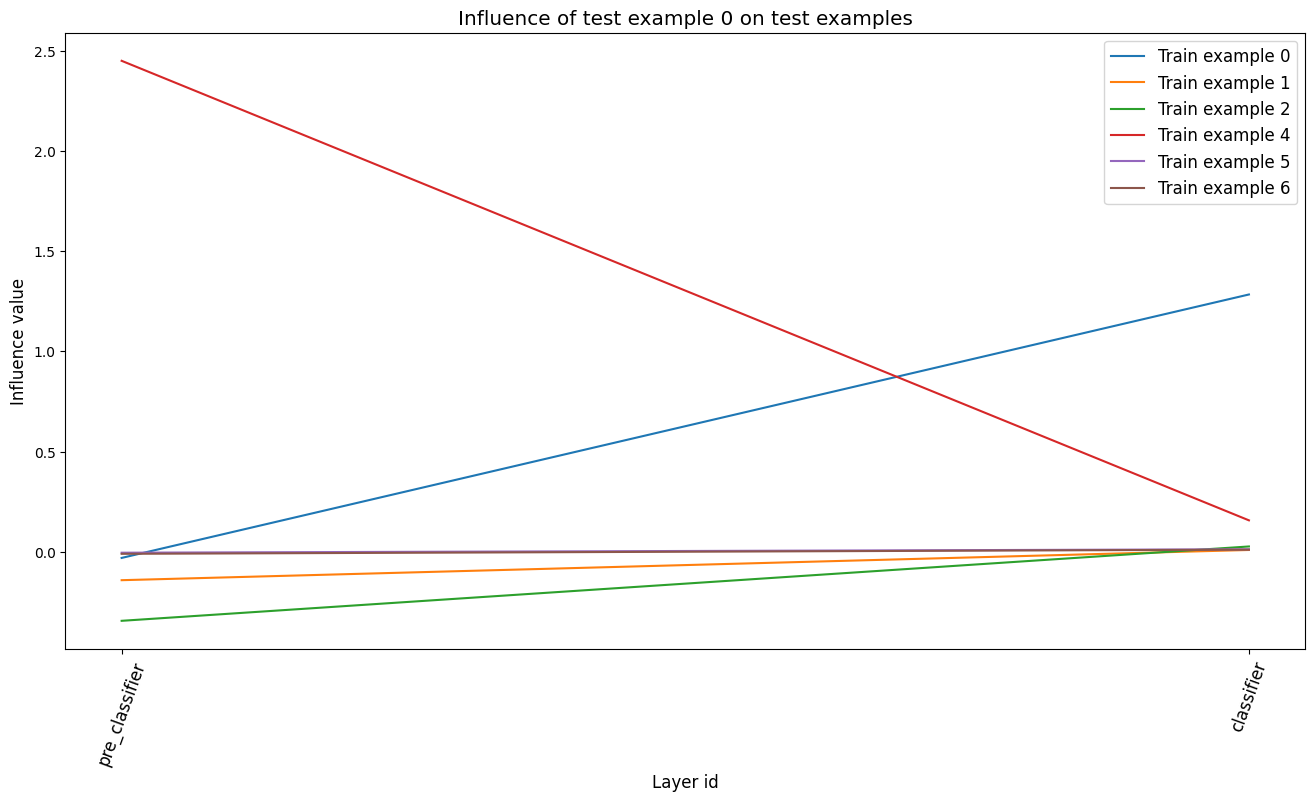

In [35]:
test_idx = 0

train_idx_to_plot = list(range(len(ekfac_train_influences[0])))
train_idx_to_plot.pop(3)
for train_idx in train_idx_to_plot:
    infl_across_layers = []
    idx = (test_idx, train_idx)
    for layer_id, value in influences_by_layer.items():
        infl_across_layers.append(value[idx].item())
    plt.plot(infl_across_layers, label=f"Train example {train_idx}")
plt.legend()
plt.xticks(
    range(len(influences_by_layer.keys())),
    strip_layer_names(influences_by_layer.keys()),
    rotation=70,
)
plt.xlabel("Layer id")
plt.ylabel("Influence value")
plt.title(f"Influence of test example {test_idx} on test examples")
plt.show()

The plot above shows the influences for test idx 0 and all train idx apart idx=3 (excluded for clarity since it has a very large absolute value). We can see that the scores tend to keep their sign across layers, but in almost all cases tend to increase when approaching the output layer. This is not always the case, and in fact other test examples show different patterns. Understanding why this happens is an interesting research direction.

## Conclusion

Ekfac is a powerful approximate method for computing the influence function of models that use a cross-entropy loss. In this notebook we applied it to sentiment analysis with BERT on the IMDB dataset. However, this method can be applied to much larger models and problems, e.g. to analyse the influence of entire sentences generated by GPT, Llama or Claude. For more info, you can visit our [paper pill on influence functions for large language models](https://transferlab.ai/pills/2023/llm-influences-with-ekfac/)

## Appendix: Choosing the Hessian regularization value

The Hessian regularization value impacts a lot the quality of the influence function approximation. In general, the value should be chosen as small as possible so that the results are finite. In practice, even when finite the influence values can be too large and lead to numerical instabilities. In this section we show how to efficiently analyse the impact of the Hessian regularization value with the ekfac method.

Let's start with a few additional imports.

In [36]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

The method `explore_hessian_regularization` will calculate the influence values of the training examples with each other for a range of Hessian regularization values. The method optimises gradient calculation and Hessian inversion to minimise the computation time.

In [37]:
influences_by_reg_value = ekfac_influence_model.explore_hessian_regularization(
    train_input,
    train_labels,
    regularization_values=[1e-15, 1e-9, 1e-5, 1],
)

/Users/jakobkruse/Documents/Projects/pyDVL/venv/lib/python3.11/site-packages/transformers/models/distilbert/modeling_distilbert.py:245: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::masked_fill.Tensor. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/BatchedFallback.cpp:85.)
  scores = scores.masked_fill(


The resulting object, `influences_by_reg_value` is a dictionary that associates to each regularization value the influences for each layer of the neural network. This is a lot of data, so we will first organise it in a pandas dataframe and take the average across training examples.

In [38]:
cols = ["reg_value", "layer_id", "mean_infl"]
infl_df = pd.DataFrame(influences_by_reg_value, columns=cols)
for reg_value in influences_by_reg_value:
    for layer_id, layer_influences in influences_by_reg_value[reg_value].items():
        mean_infl = torch.mean(layer_influences, dim=0).detach().numpy()
        infl_df = pd.concat(
            [infl_df, pd.DataFrame([[reg_value, layer_id, mean_infl]], columns=cols)]
        )

/var/folders/7z/vpl48vzj3j797nv0d62y1g500000gn/T/ipykernel_9284/1081261490.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  infl_df = pd.concat(


With this dataframe, we can take contiguous values of regularization and, for each layer, calculate the Pearson and Spearman correlation coefficients. This will give us an idea of how the influence values change with the regularization value.

In [39]:
result_corr = {}
for layer_id, group_df in infl_df.groupby("layer_id"):
    result_corr[layer_id + "_pearson"] = {}
    result_corr[layer_id + "_spearman"] = {}
    for idx, mean_infl in enumerate(group_df["mean_infl"]):
        if idx == 0:
            continue
        reg_value_diff = f"Reg: {group_df['reg_value'].iloc[idx-1]} -> {group_df['reg_value'].iloc[idx]}"
        pearson = pearsonr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        spearman = spearmanr(mean_infl, group_df["mean_infl"].iloc[idx - 1]).statistic
        result_corr[layer_id + "_pearson"].update({f"{reg_value_diff}": pearson})
        result_corr[layer_id + "_spearman"].update({f"{reg_value_diff}": spearman})
result_df = pd.DataFrame(result_corr).T

Let's plot the correlations heatmap. The y-axis reports Spearman and Pearson correlations for each layer, while the x-axis reports pairs of regularization values. High correlations mean that influences are stable across regularization values. 

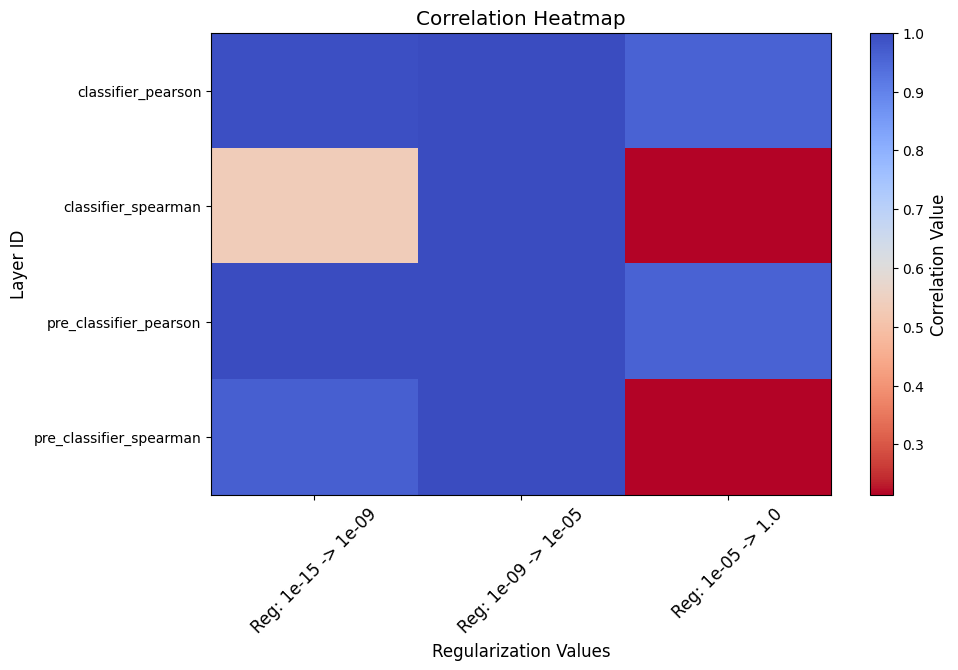

In [40]:
plt.figure(figsize=(10, 6))
plt.imshow(result_df, cmap="coolwarm_r", aspect="auto")
plt.xticks(range(result_df.shape[1]), result_df.columns, rotation=45)
plt.yticks(range(result_df.shape[0]), strip_layer_names(result_df.index))
plt.colorbar(label="Correlation Value")
plt.title("Correlation Heatmap")
plt.xlabel("Regularization Values")
plt.ylabel("Layer ID")
plt.show()

In our case, we can see that for regularization = 1 the spearman correlation becomes very bad. However, for a large range of regularization values smaller than 1 the sample rankings are stable. This is a good indicator that the model is not too sensitive to the regularization value. We therefore chose the value 1e-5 for our analysis.